In [33]:
# https://qiita.com/KamikawaTakato/items/67abef07cd713b0b5c5f
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

#画像中の物体検出
#必要なライブラリのimport
#Colabには標準でインストールされているのでinstallの必要はなし

import torch #深層学習用ライブラリの一つであるpytorchをimport
import PIL #画像処理用ライブラリの一つPILをimport
from PIL import Image #PILからImageをimport
import torchvision #pytorchの画像処理用ライブラリをimport
from torchvision import transforms #画像処理用ライブラリからtransformsをimport
import cv2 #画像処理用ライブラリ
import matplotlib.pyplot as plt #グラフや画像を表示するためのライブラリをimport

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Check for CUDA availability

In [34]:
#画像を読み込む
frame_raw = cv2.imread('test_img1.jpg')


#PILの画像配列にすればモデルに入力しやすいのでPILの配列に変換
#cv2はBGRの順番だがPILはRGBの順番
frame = cv2.cvtColor(frame_raw,cv2.COLOR_BGR2RGB)#BGRの順番になっているのをRGBに並べ替える

#numpy→PIL
image = Image.fromarray(frame) #numpyのarrayから変換

#モデルをダウンロード

#Faster R-CNNはこちら
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)  # モデルをGPUに転送
#Mask R-CNNを試したい場合は、一行下のコードのコメントアウト(#)を外す
#model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

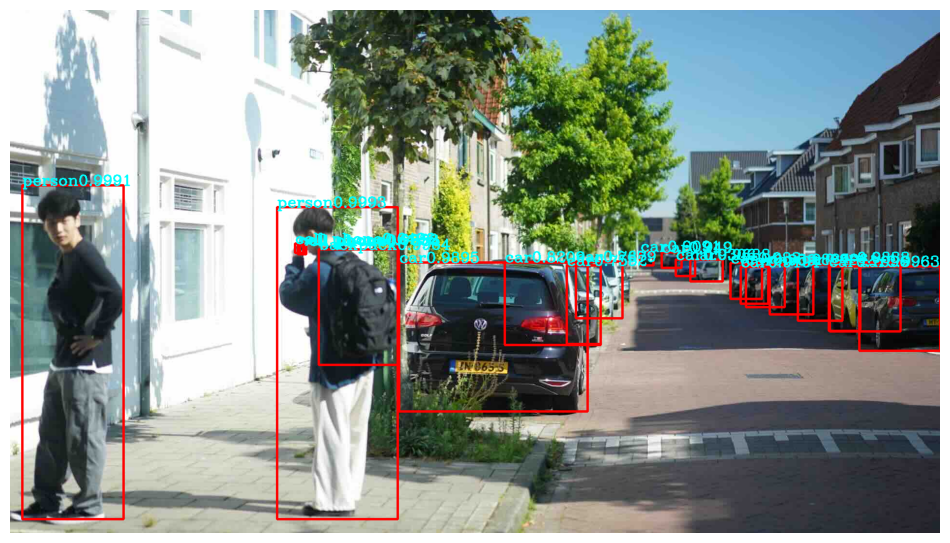

In [35]:
#いよいよ推論！！
with torch.no_grad(): #pytorchの自動微分機能を切る
    #推論に使うデバイスを選択(GPUを使用する場合は　torch.device('cuda'))
    # device = torch.device('cuda') 
    transform = transforms.Compose([transforms.ToTensor()]) #PILをtensorに変換にするためのインスタンスを用意
    # inputs = transform(image) #PIL→tensor
    # inputs = inputs.unsqueeze(0).to(device)#デバイスに入力
    inputs = transform(image).unsqueeze(0).to(device)
    model.eval() #モデルを推論モードに切り替え
    outputs = model(inputs) #モデルに推論させて結果を受け取る
    for i in range(len(outputs[0]['boxes'])):
        # Convert coordinates to integers *before* using them
        x0 = int(outputs[0]['boxes'][i][0].item()) #.item() is crucial when working with tensors
        y0 = int(outputs[0]['boxes'][i][1].item())
        x1 = int(outputs[0]['boxes'][i][2].item())
        y1 = int(outputs[0]['boxes'][i][3].item())

        if outputs[0]['scores'][i] >= 0.6:
            bbox = cv2.rectangle(frame_raw, (x0, y0), (x1, y1), (0, 0, 255), 3, 4)
            class_num = outputs[0]['labels'][i]
            class_name = COCO_INSTANCE_CATEGORY_NAMES[class_num]
            conf = float(outputs[0]['scores'][i])
            conf = round(conf,4)
            label = class_name + str(conf)
            bbox = cv2.putText(bbox,label,(x0,y0),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,0),2 )
            # ... (rest of your drawing and labeling code)
    plt.figure(figsize=(12, 9))
    plt.imshow(cv2.cvtColor(bbox, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    
   
